# Problem 2

In [98]:
from __future__ import print_function
import time
import numpy as np
import gzip
import pickle

In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torchvision
import torchvision.transforms
import matplotlib.pyplot as plt

### Data loading and DataLoaders creation

In [121]:
f = gzip.open('mnist.pkl.gz') 
mnist = pickle.load(f, encoding='latin1')

In [127]:
mnist_train_features = np.concatenate((mnist[0][0], mnist[1][0]), axis=0) #(60000,784)
mnist_train_labels = np.concatenate((mnist[0][1], mnist[1][1]), axis=0)  #(60000,1)

mnist_valid_features = mnist[2][0]  #(10000,784)
mnist_valid_labels = mnist[2][1]    #(10000,1)

In [142]:
mnist_train_features = mnist_train_features.reshape((60000,1,28,28))
mnist_valid_features = mnist_valid_features.reshape((10000,1,28,28))

# Reduce the dataset size for testing, if needed (ex: X_train = mnist_train_features[0:10000])
mnist_train = torch.utils.data.TensorDataset(torch.tensor(mnist_train_features[0:60000]), torch.tensor(mnist_train_labels[0:60000]))
mnist_test = torch.utils.data.TensorDataset(torch.tensor(mnist_valid_features[0:10000]), torch.tensor(mnist_valid_labels[0:10000]))

In [148]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True, num_workers=2)

### CNN model definition

In [144]:
class Classifier(nn.Module):
    """Convnet Classifier"""
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            
            # Layer 2
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=96, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4
            nn.Conv2d(in_channels=128, out_channels=192, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 5
            nn.Conv2d(in_channels=192, out_channels=256, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2)
        )
        # Logistic Regression
        self.clf = nn.Linear(256, 10)

    def forward(self, x):
        return self.clf(self.conv(x).squeeze())


In [145]:
cuda_available = torch.cuda.is_available()
print(cuda_available)

True


### CNN model instanciation and training

In [173]:
clf = Classifier()
if cuda_available:
    clf = clf.cuda()
optimizer = torch.optim.SGD(clf.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()
# This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.

In [174]:
dict_err, dict_loss = {}, {}
dict_err["tr"] = []
dict_err["val"] = []
dict_loss["tr"] = []
dict_loss["val"] = []
for epoch in range(10):
    tr_total = 0
    tr_correct = 0
    # Train
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()
        outputs = clf(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        tr_loss = loss.data.item()
        _, predicted = torch.max(outputs.data, 1)
        tr_total += targets.size(0)
        tr_correct += predicted.eq(targets.data).cpu().sum()
        tr_err = np.float32(tr_correct)/np.float32(tr_total)
    dict_loss["tr"].append(tr_loss)
    dict_err["tr"].append(tr_err)
    
    # Evaluate
    clf.eval()
    val_total = 0
    val_correct = 0
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        outputs = clf(inputs)
        loss = criterion(outputs, targets)
        val_loss = loss.data.item()
        _, predicted = torch.max(outputs.data, 1)
        val_total += targets.size(0)
        val_correct += predicted.eq(targets.data).cpu().sum()
        val_err = np.float32(val_correct)/np.float32(val_total)
    dict_loss["val"].append(val_loss)
    dict_err["val"].append(val_err)

    
    print('Epoch %d :' % (epoch))
    print('Training Loss: %.4f  Accuracy: %.4f' % (tr_loss, tr_err))
    print('Validation Loss: %.4f  Accuracy: %.4f' % (val_loss, val_err))
    print('--------------------------------------------------------------')
    clf.train()



Epoch 0 :
Training Loss: 1.8023  Accuracy: 0.2234
Validation Loss: 1.7035  Accuracy: 0.4921
--------------------------------------------------------------
Epoch 1 :
Training Loss: 0.2641  Accuracy: 0.8469
Validation Loss: 0.3617  Accuracy: 0.8827
--------------------------------------------------------------
Epoch 2 :
Training Loss: 0.1809  Accuracy: 0.9541
Validation Loss: 0.1043  Accuracy: 0.9465
--------------------------------------------------------------
Epoch 3 :
Training Loss: 0.0975  Accuracy: 0.9693
Validation Loss: 0.0228  Accuracy: 0.9670
--------------------------------------------------------------
Epoch 4 :
Training Loss: 0.0474  Accuracy: 0.9764
Validation Loss: 0.1405  Accuracy: 0.9798
--------------------------------------------------------------
Epoch 5 :
Training Loss: 0.0581  Accuracy: 0.9792
Validation Loss: 0.0073  Accuracy: 0.9753
--------------------------------------------------------------
Epoch 6 :
Training Loss: 0.0340  Accuracy: 0.9818
Validation Loss: 0.0

### Printing graphics...

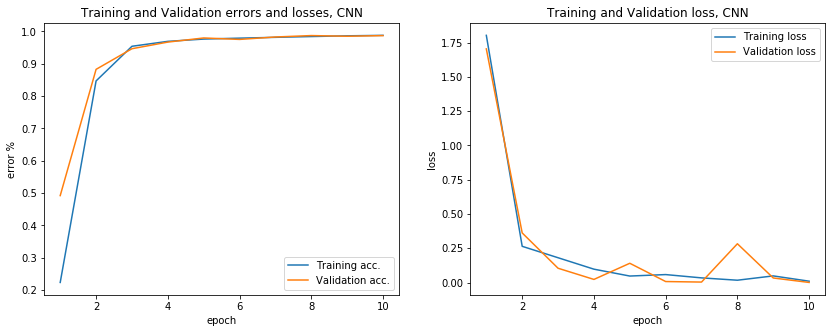

In [175]:
x = np.arange(1,len(dict_err["tr"])+1,1)
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.title("Training and Validation errors and losses, CNN")
plt.plot(x, dict_err["tr"], label="Training acc.")
plt.plot(x, dict_err["val"], label="Validation acc.")
plt.xlabel("epoch")
plt.ylabel("error %")
plt.legend()
plt.subplot(1,2,2)
plt.title("Training and Validation loss, CNN")
plt.plot(x, dict_loss["tr"], label="Training loss")
plt.plot(x, dict_loss["val"], label="Validation loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()